In [1]:
#import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Function to compute Backward Energy
Backward Energy is the squared sum of difference in individual component of 4-directionally adjacent pixel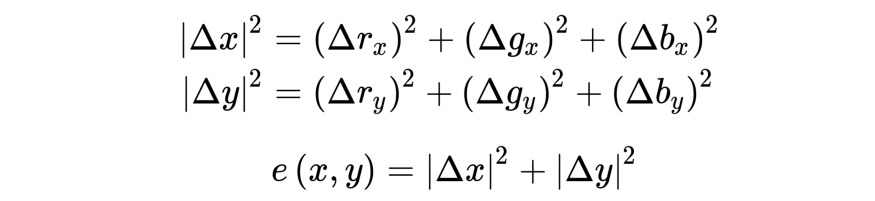
Calculate this for all valid adjacent pixel
Take care of corner cases

In [2]:
def backward_energy(image):
    image = image.astype(np.float64)
    h,w=image.shape[:2]               # height,width of image
    energy=np.zeros((h,w))            
    for i in range(h):
        for j in range(w):
            s=0
            # compute backward energy for pixel (i,j)
            if i-1>=0:
                s=s+(image[i][j][0]-image[i-1][j][0])**2 + (image[i][j][1]-image[i-1][j][1])**2 + (image[i][j][2]-image[i-1][j][2])**2
            if i+1<h:
                s=s+(image[i][j][0]-image[i+1][j][0])**2 + (image[i][j][1]-image[i+1][j][1])**2 + (image[i][j][2]-image[i+1][j][2])**2
            if j-1>=0:
                s=s+(image[i][j][0]-image[i][j-1][0])**2 + (image[i][j][1]-image[i][j-1][1])**2 + (image[i][j][2]-image[i][j-1][2])**2
            if j+1<w:
                s=s+(image[i][j][0]-image[i][j+1][0])**2 + (image[i][j][1]-image[i][j+1][1])**2 + (image[i][j][2]-image[i][j+1][2])**2
            energy[i][j]=np.sqrt(s)
    return energy

## Function to computer Forward Energy
Forward Energy of pixel ( i , j ) is the sum of squared difference of pixels which become adjacent after removal of (i,j) pixel

In [3]:
def forward_energy(image):
    h, w = image.shape[:2]
    image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float64)

    energy = np.zeros((h, w))
    m = np.zeros((h, w))
    
    U = np.roll(image, 1, axis=0)
    L = np.roll(image, 1, axis=1)
    R = np.roll(image, -1, axis=1)
    
    cU = np.abs(R - L)
    cL = np.abs(U - L) + cU
    cR = np.abs(U - R) + cU
    
    for i in range(1, h):
        mU = m[i-1]
        mL = np.roll(mU, 1)
        mR = np.roll(mU, -1)
        
        mULR = np.array([mU, mL, mR])
        cULR = np.array([cU[i], cL[i], cR[i]])
        mULR += cULR

        argmins = np.argmin(mULR, axis=0)
        m[i] = np.choose(argmins, mULR)
        energy[i] = np.choose(argmins, cULR)
    
    return energy

## Next Step is to Apply Dynamic programming to calculate the minimum energy seam path
### Base Case
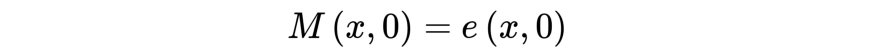

### Recurrence Relation
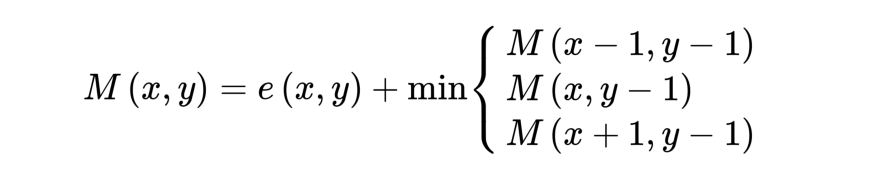

In [4]:
def find_seam(image,mask=None):
    energy=forward_energy(image)                     # compute energy of image
    if mask is not None:
        energy[np.where(mask > 10)] = 100000.0
    h,w=energy.shape[0:2]
    index=np.zeros((h,w),dtype=np.int)               #index to store index of previous row minimum to backtrack to get seam coordinates
    seam_mask = np.ones((h, w), dtype=np.bool)       #seam_mask True to take this pixel False to remove this pixel
    for i in range(1,h):
        for j in range(w):
            if j==0:
                idx=np.argmin(energy[i-1,j:j+2])
                idx+=j
            elif j==w-1:
                idx=np.argmin(energy[i-1,j-1:j+1])
                idx+=j-1
            else:
                idx=np.argmin(energy[i-1,j-1:j+2])
                idx+=j-1
            energy[i][j]+=energy[i-1][idx]
            index[i][j]=idx
    idx=np.argmin(energy[-1])
    i=h-1;
    seam_index=[]
    #backtracking to find coordinates of seam
    while i>=0:
        seam_index.append(idx)
        seam_mask[i][idx]=False
        idx=index[i][idx]
        i-=1
    seam_index.reverse()
    return seam_mask,np.array(seam_index)

### Some Utility functions

In [5]:
# function to remove seam from the image
def remove_image_seam(im, seam_mask):
    h, w = im.shape[:2]
    seam_mask3c = np.stack([seam_mask] * 3, axis=2)
    return im[seam_mask3c].reshape((h, w - 1, 3))

In [6]:
# function to remove seam from mask
def remove_mask_seam(mask,seam_mask):
    h,w=mask.shape[:2]
    return mask[seam_mask].reshape(h,w-1)

In [7]:
# function to rotate image
def rotate_image(image,clockwise):
    k=1 if clockwise else 3
    return np.rot90(image,k)

In [8]:
# save the image with seam marker of black color
def save_seam_image(image,seam_mask,i,axis):
    if axis=="y":
        image=rotate_image(image,True)
        seam_mask=rotate_image(seam_mask,True)
    seamed_image=image;
    seamed_image[np.where(seam_mask==False)]=[0,0,0]
    filename='SEAMED/SEAMED_' + axis + '_' + str(i) + '.jpg'
    cv2.imwrite(filename,seamed_image)

In [9]:
# function to add seam of the image
def add_image_seam(image,seam):
    h,w=image.shape[:2]
    output=np.zeros((h,w+1,3))
    for row in range(h):
        idx=seam[row]
        for ch in range(3):
            if idx==0:
                p=np.average(image[row,idx:idx+2,ch])          # take average of index at left and right of seam_idx
                output[row,idx,ch]=image[row,idx,ch]
                output[row,idx+1,ch]=p
                output[row,idx+2:,ch]=image[row,idx+1:,ch]
            else:
                p=np.average(image[row,idx-1:idx+1,ch])
                output[row,:idx,ch]=image[row,:idx,ch]
                output[row,idx,ch]=p
                output[row,idx+1:,ch]=image[row,idx:,ch]
    return output

In [10]:
def increase_size_util(image,num,mask):
    seam_arr=[]
    temp_image=image.copy()
    temp_mask=mask.copy() if mask is not None else None
    for i in range(num):
        seam_mask,seam_idx=find_seam(temp_image,mask)
        seam_arr.append(seam_idx)
        temp_image=remove_image_seam(temp_image,seam_mask)
        if temp_mask is not None:
            temp_mask=remove_mask_seam(temp_mask,seam_mask)
            
    seam_arr.reverse()
    for i in range(num):
        seam=seam_arr[i]
        image=add_image_seam(image,seam)
        if mask!=None:
            mask=add_mask_seam(mask,seam)
        for j in range(i+1,num):
            seam_arr[j][np.where(seam_arr[j]>=seam)]+=1
    return image

### Function To Decrease Image Size

In [11]:
def decrease_image_size(image,dx,dy,mask=None):
    for i in range(dx):
        seam_mask,seam_arr=find_seam(image,mask)
        save_seam_image(image,seam_mask,i,"x")
        image=remove_image_seam(image,seam_mask)
    
    image=rotate_image(image,False)
    for i in range(dy):
        seam_mask,seam_arr=find_seam(image,mask)
        save_seam_image(image,seam_mask,i,"y")
        image=remove_image_seam(image,seam_mask)
        
    image=rotate_image(image,True)
    return image
    

### Function To Increase Image Size

In [12]:
def increase_image_size(image,dx,dy,mask=None):
    if dx>0:
        image=increase_size_util(image,dx,mask)
    if dy>0:
        image=rotate_image(image,False)
        image=increase_size_util(image,dy,mask)
        image=rotate_image(image,True)
    return image

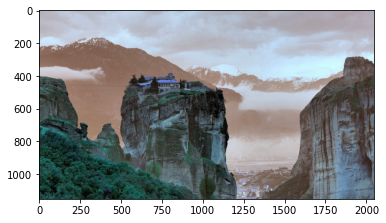

In [13]:
image=cv2.imread('IMG.jpeg',cv2.IMREAD_COLOR)
plt.imshow(image)

In [14]:
print(image.shape)

(1152, 2048, 3)


#### Decreasing image size

In [15]:
image=decrease_image_size(image,100,0)

In [16]:
print(image.shape)

(1152, 1948, 3)


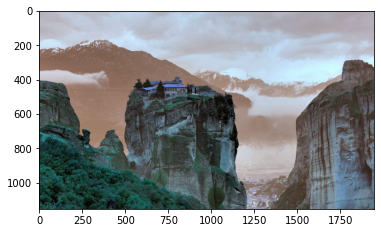

In [17]:
plt.imshow(image)